# Support Vector Machine (SVM)

## 0. Notations

* $(x_n, y)_{n=1}^{N}$ - training set
* $x_n \in R^d$ - feature object description
* $y$ - class label

## 1. Linear separable case with 2 classes

Idea of this method is based on assumptions, that if two classes a linear separable, then exists such hyperplane ($\exists \text{ } w, b$ - parameters of hyperplane) s.t.

$$\begin{equation*}
 \begin{cases}
   w^Tx_n+b > 0, y = 1\\
   w^Tx_n+b < 0, y = - 1
 \end{cases}
\end{equation*}$$

How can we construct such hyperplane?

Define the distance from the hyperplane to the class as minimum distance between the hyperplane and the class object. Let $d_+$ and $d_{-}$ be the distance from hyperplane to the class $1$ and $2$ respectively. Thus, optimal separating hyperplne is defined by following condition:

$$max_{w, b}(min(d_{+}, d_{-})).$$

Intuitively, the optimal hyperplane must always pass in the middle between classes, then we assume that $d_{-} = d+{+}.$ 

Note, that optimal hyperplane determined up to measurment scale. Namely, the optimal hyperplane will not change if it is multiplied by some constant: equality $w^Tx_n+b = 0$ remains. Define level lines passing through the nearest objects of classes as:

$$\begin{equation*}
 \begin{cases}
   w^Tx_n+b = 1 \\
   w^Tx_n+b = -1
 \end{cases}
\end{equation*}$$


Consider arbitrary vector $u_1$, which belongs to optimal hyperplane, and $u_2$ - arbitrary vector, which belongs to level line $w^Tx_n+b = 1$:

$$\begin{equation*}
 \begin{cases}
   w^Tu_1+b = 0 \\
   w^Tu_2+b = 1 
 \end{cases}
\end{equation*}
$$


$$\to  w^T(u_2-u_1) = 1 $$

$$\frac{1}{||w||}w^T(u_2-u_1) = pr_w(u_2-u_1) = \frac{1}{||w||} = d_{-} = d_{+}.$$


Thus, task of maximazing distance between to classes can be rewritten as follows:
$$\begin{equation*}
 \begin{cases}
   \frac{2}{||w||} \to max\\
   y(w^Tx_n+b) \geq 1 
 \end{cases}
\end{equation*}
$$

Which is equal to:

$$\begin{equation*}
 \begin{cases}
   \frac{1}{2} ||w||^2 \to min\\
   y(w^Tx_n+b) \geq 1 
 \end{cases}
\end{equation*}
$$

Adding square doesn't change the optimal solution, but leads to easier convex task.  

## 2. Сase of arbitrary data (2 classes)

It means, that exist such examples for which inequalities from the previous system of equations may not hold. Then we can make these inequalities softer:

$$\begin{equation*}
   y(w^Tx_n+b) \geq 1 - \varepsilon_n, n=\overline{1,N}
\end{equation*}
$$
where $\varepsilon_n \geq 0.$ 

Object will classify correctly if $d_+$, $d_-$ will lies between 0 and 1, but with penalty.

Note the difficulty that we have in this case:

We want to minimize $\sum_{n}\varepsilon_n$, but we want to maximize distance between to classes. These tasks contradict each other. When we maximize distance, $\sum_{n}\varepsilon_n$ growths, but when we minimize $\sum_{n}\varepsilon_n$ we adjust too much to the dataset and as the result got a small distance between classes. Trade-off in this case will be the following system: 

$$\begin{equation*}
 \begin{cases}
   \frac{1}{2} ||w||^2  + C \sum_{n}\varepsilon_n \to min\\
   y(w^Tx_n+b) \geq 1 - \varepsilon_n \\
   \varepsilon_n \geq 0, n=\overline{1,N}
 \end{cases}
\end{equation*}
$$

The grater $C$, the more we adjust to the training sample, the smaller the gap between classes we got.

## 3. Unconditional minimization

In the classification problem, objective function is the upper estimate of the proportion of incorrect answers. Linear and logistic classificators are formulated in this way.

Reformulate SVM in this way too.

From previous system we get:
$$\begin{equation*}
 \begin{cases}
   \varepsilon_i \geq 1 - (y_i(<w,x_i>+b))\\
   \varepsilon_i\geq 0
 \end{cases}
\end{equation*}
$$

What is equivalently to:

$$\varepsilon_i = max(0, 1-y_i(<w,x_i>+b))$$

Finally, we get:

$$\frac{1}{2} ||w||^2  + C \sum_{n} max(0, 1-y_i(<w,x_i>+b)) \to \min_{w,b}$$

This problem is not smooth, so solving it is quite difficult. Therefore, the SVM is solved as a problem of conditional minimization.

## 4. Practice: SVM from scratch

In [146]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import cvxopt
import numexpr
import scipy
import sklearn.datasets as ds


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

Check results on data set Iris

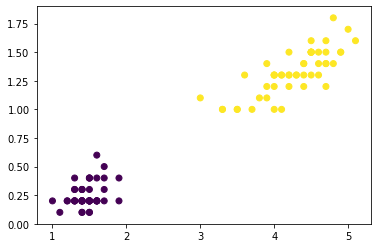

In [154]:
# Upload data
from sklearn import datasets 

iris = datasets.load_iris() 

x = iris.data[:, [2, 3]]
y = iris.target

# Prepare data for perceptron
x, y = x[y!=2], np.where(y[y!=2] == 1, 1, -1)

# Visualize data
plt.scatter(x[:,0], x[:,1], c=y)     
plt.show()

In [155]:
xl, x_test, yl, y_test = train_test_split(x,y,test_size=0.1,random_state=10)

Create SVM with Gaussian Kernel, for optomization will use CVXOPT (https://cvxopt.org/userguide/coneprog.html).

In [156]:
class SVM:
    
    def __init__(self,C: float = 1, gamma = None, threshold=1e-3):
        
        self.C = C
        self.gamma = gamma
        self.threshold = threshold
        
    def X_rbf_kernel(self, X):

        X_norm = - self.gamma * np.einsum("ij,ij->i", X, X)
        return numexpr.evaluate(
            "exp(A + B + C)",
            dict(
                A=X_norm[None, :],
                B=X_norm[:, None],
                C=scipy.linalg.blas.sgemm(alpha=2.0 * self.gamma, a=X, b=X, trans_b=True),
            ),
        )
    
    def fit(self, X, targets):
        
        N, n_features = np.shape(X)
        
        if self.gamma is None:
            self.gamma = 1 / (np.var(X) * n_features)

        K = self.X_rbf_kernel(X)
        
        
        P = targets * targets.transpose() * K
        q = -np.ones((N,1))
        G = np.concatenate((np.eye(N),-np.eye(N)))
        h = np.concatenate((self.C*np.ones((N,1)),np.zeros((N,1))))
        A = targets.reshape(1,N)
        b = 0.0

        sol = cvxopt.solvers.qp(cvxopt.matrix(P),cvxopt.matrix(q),cvxopt.matrix(G),
                                cvxopt.matrix(h), cvxopt.matrix(A, tc="d"), cvxopt.matrix(b))
        
        lambdas = np.array(sol['x'])
        self.sv = np.where(lambdas > self.threshold)[0]        
        self.nsupport = len(self.sv)
        self.X = X[self.sv,:]
        self.lambdas = lambdas[self.sv]
        self.targets = targets[self.sv]
        
        self.b = np.sum(self.targets)
        for n in range(self.nsupport):
            self.b -= np.sum(self.lambdas * self.targets * np.reshape(K[self.sv[n],self.sv], (self.nsupport,1)))
        self.b /= len(self.lambdas)
       
            
    def predict(self, target):
        
        K = np.dot(target, self.X.T)
        
        for i in range(K.shape[0]):
            K[i,:] /= np.linalg.norm(target[i])
            
        for j in range(K.shape[1]):
            K[:, j] /= np.linalg.norm(self.X[j])

        self.y = np.zeros((np.shape(target)[0],1))
        
        for j in range(np.shape(target)[0]):
            for i in range(self.nsupport):
                
                self.y[j] += self.lambdas[i]*self.targets[i]*K[j,i]
                
            self.y[j] += self.b

        return np.sign(self.y).reshape((1,-1))[0]

In [157]:
svc = SVM(C=1, gamma=2, threshold=1e-3)

In [158]:
svc.fit(xl, yl)

     pcost       dcost       gap    pres   dres
 0: -8.8770e-01 -1.0048e+02  1e+02  2e-16  3e-16
 1: -1.7546e+00 -4.7128e+00  3e+00  3e-16  4e-16
 2: -1.9907e+00 -2.5593e+00  6e-01  2e-16  2e-16
 3: -2.0906e+00 -2.2100e+00  1e-01  3e-16  2e-16
 4: -2.1232e+00 -2.1502e+00  3e-02  7e-16  2e-16
 5: -2.1301e+00 -2.1362e+00  6e-03  2e-16  2e-16
 6: -2.1325e+00 -2.1327e+00  2e-04  2e-16  2e-16
 7: -2.1326e+00 -2.1326e+00  6e-06  2e-16  2e-16
 8: -2.1326e+00 -2.1326e+00  9e-08  2e-16  2e-16
Optimal solution found.


In [159]:
predictions = svc.predict(x_test)

In [160]:
accuracy_score(predictions, y_test)

0.7